In [5]:
import sys
from pathlib import Path
sys.path.append("../src/")
sys.path.append("../src/AtomicH")
sys.path.append("../src/AtomicH/LitReview")
import numpy as np
import pylab as plt
import json
import os
import elastic
import constants
import potentials
import dipolelosses
from dipolelosses import DipoleChannels
import spinexchange
from spinexchange import SpinExChannels


try:
    here = Path(__file__).resolve().parent
except NameError:
    here = Path.cwd()              

src_root = (here / ".." / "src").resolve()
if str(src_root) not in sys.path:    
    sys.path.insert(0, str(src_root))

In [6]:
B_values = np.logspace(-3,1,50)

T   = 5e-5

GVsB_HDip=[]
GVsB_TDip=[]

for c in DipoleChannels:
    Gs=[]
    for B in B_values:
        Gs.append(dipolelosses.GetGFactor(
            c,  B, constants.HydrogenConstants, T, potentials.Silvera_Triplet,rhos=np.linspace(1e-9,0.75,2000),lin=0,lout=2)
        )
    GVsB_HDip.append(np.array(Gs))
    Gs=[]

    for B in B_values:
        Gs.append(dipolelosses.GetGFactor(
            c,  B, constants.TritiumConstants, T, potentials.Silvera_Triplet,rhos=np.linspace(1e-9,0.75,2000),lin=0,lout=2)
        )
    GVsB_TDip.append(np.array(Gs))

In [7]:
B_values = np.logspace(-3,1,50)
potT     = potentials.Silvera_Triplet
potS     = potentials.Kolos_Singlet2_VDW

T        = 1e-5

GVsB_HEx=[]
GVsB_TEx=[]

for c in SpinExChannels:
    Gs=[]
    for B in B_values:
        Gs.append(spinexchange.GetGFactor(c,  B, constants.HydrogenConstants(), T, potT,potS,l=0,rhos=np.linspace(1e-9,0.75,2000)))
    GVsB_HEx.append(np.array(Gs))
    Gs=[]

    for B in B_values:
        Gs.append(spinexchange.GetGFactor(c,  B, constants.TritiumConstants(), T, potT,potS,l=0,rhos=np.linspace(1e-9,0.75,2000)))
    GVsB_TEx.append(np.array(Gs))

In [8]:
# To make the plots with real B on x axis
#B_display=B_values

# To make the plots with Stoof scaled B on x axis
B_display=dipolelosses.B_Naught(B_values)

In [9]:
json_path = os.path.join(
    here, "..", "src", "AtomicH", "LitReview", "Stoof_Exchange_Channels_dd2aa_dd2ad_Mag.json"
)
with open(json_path, "r") as f:
    data = json.load(f)
    
ccaa       = data["datasetColl"][0]["data"]
B_ccaa     = np.array([pt["value"][0] for pt in ccaa])
G_ccaa     = np.array([pt["value"][1] for pt in ccaa])  

ccbd       = data["datasetColl"][1]["data"]
B_ccbd     = np.array([pt["value"][0] for pt in ccbd])
G_ccbd     = np.array([pt["value"][1] for pt in ccbd])  

ccac       = data["datasetColl"][2]["data"]
B_ccac     = np.array([pt["value"][0] for pt in ccac])
G_ccac     = np.array([pt["value"][1] for pt in ccac])  

ddaa       = data["datasetColl"][3]["data"]
B_ddaa     = np.array([pt["value"][0] for pt in ddaa])
G_ddaa     = np.array([pt["value"][1] for pt in ddaa])   

ddad       = data["datasetColl"][4]["data"]
B_ddad     = np.array([pt["value"][0] for pt in ddad])
G_ddad     = np.array([pt["value"][1] for pt in ddad])   

In [10]:
json_path = os.path.join(
    here, "..", "src", "AtomicH", "LitReview", "Stoof_dd2ac_Mag.json"
)
with open(json_path, "r") as f:
    data = json.load(f)

ddac       = data["datasetColl"][0]["data"]    
B_ddac     = np.array([pt["value"][0] for pt in ddac])
G_ddac     = np.array([pt["value"][1] for pt in ddac])   

In [11]:
json_path = os.path.join(
    here, "..", "src", "AtomicH", "LitReview", "Stoof_dd2cc_dd2cd_Mag.json"
)
with open(json_path, "r") as f:
    data = json.load(f)

ddcc       = data["datasetColl"][0]["data"]    
B_ddcc     = np.array([pt["value"][0] for pt in ddcc])
G_ddcc     = np.array([pt["value"][1] for pt in ddcc])  

ddcd       = data["datasetColl"][1]["data"]    
B_ddcd     = np.array([pt["value"][0] for pt in ddcd])
G_ddcd     = np.array([pt["value"][1] for pt in ddcd])  

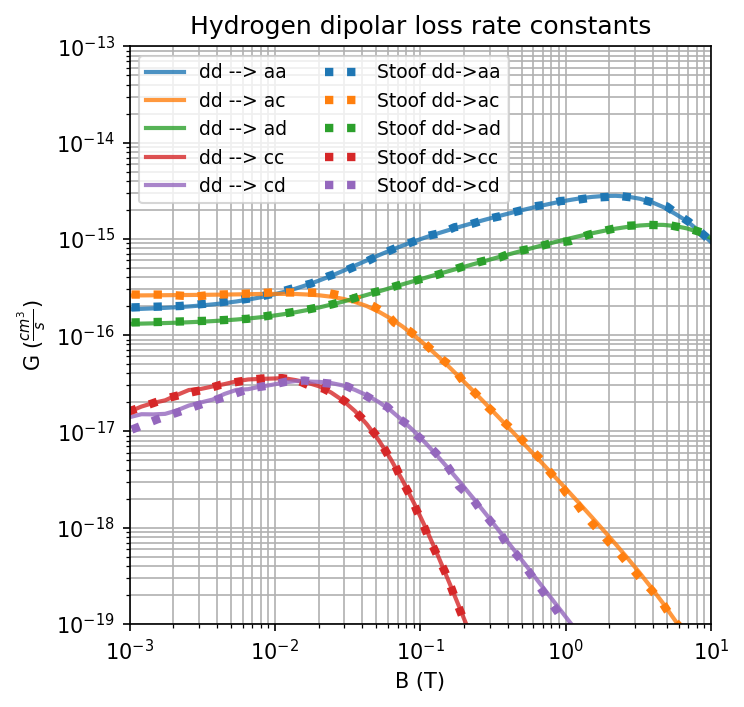

In [12]:
plt.figure(figsize=(5,5),dpi=150)
B_values = np.logspace(-3,1,50)

colors=plt.rcParams['axes.prop_cycle'].by_key()['color']

c=0
for ci in range(0,len(DipoleChannels)):
    Label='dd --> '+str(DipoleChannels[ci]['alphaprime'])+str(DipoleChannels[ci]['betaprime'])
    plt.plot(B_values,GVsB_HDip[ci],label=Label,color=colors[c],linewidth=2,alpha=0.8)
    c=c+1
    plt.semilogy()

plt.plot(dipolelosses.Invert_B_Naught(B_ddaa),G_ddaa,':',label="Stoof dd->aa",color=colors[0],linewidth=4)
plt.plot(dipolelosses.Invert_B_Naught(B_ddac),G_ddac,':',label="Stoof dd->ac",color=colors[1],linewidth=4)
plt.plot(dipolelosses.Invert_B_Naught(B_ddad),G_ddad,':',label="Stoof dd->ad",color=colors[2],linewidth=4)
plt.plot(dipolelosses.Invert_B_Naught(B_ddcc),G_ddcc,':',label="Stoof dd->cc",color=colors[3],linewidth=4)
plt.plot(dipolelosses.Invert_B_Naught(B_ddcd),G_ddcd,':',label="Stoof dd->cd",color=colors[4],linewidth=4)

plt.xlabel("B (T)")
plt.xlim(1e-3, 10)
plt.ylabel(r'G ($\frac{cm^3}{s}$)')
plt.ylim(1e-19, 1e-13)
plt.title("Hydrogen dipolar loss rate constants")
plt.grid(which='both')
plt.legend(ncol=2,fontsize=9,loc='upper left')
plt.loglog()
plt.savefig("Plots/LitComparison_dipolechannels.png",dpi=250,bbox_inches='tight')

plt.show()

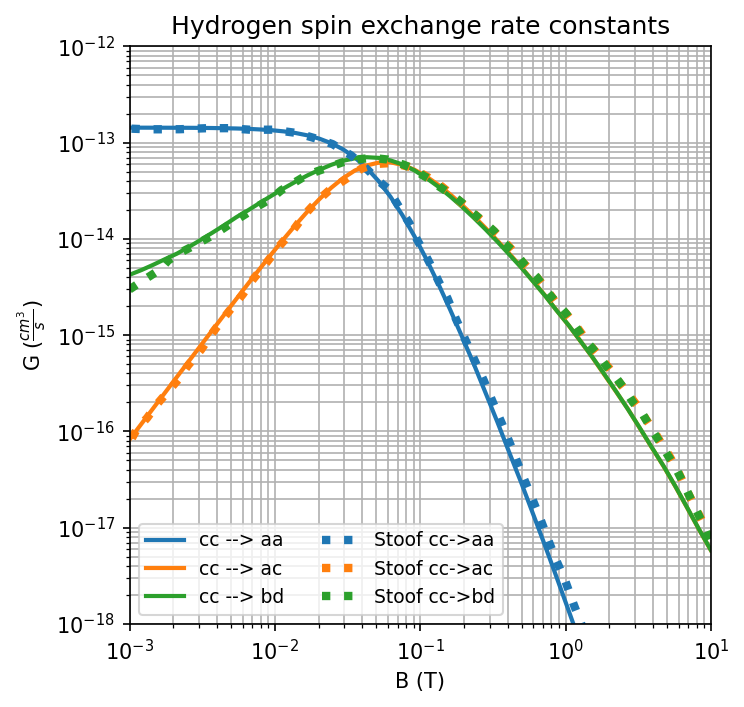

In [13]:
plt.figure(figsize=(5,5),dpi=150)
B_values = np.logspace(-3,1,50)

for ci in range(0,len(SpinExChannels)):
    Label='cc --> '+str(SpinExChannels[ci]['alphaprime'])+str(SpinExChannels[ci]['betaprime'])
    plt.plot(B_values, GVsB_HEx[ci],label=Label,color=colors[ci],linewidth=2)
    plt.semilogy()


plt.plot(dipolelosses.Invert_B_Naught(B_ccaa),G_ccaa,':',label="Stoof cc->aa",color=colors[0],linewidth=4)
plt.plot(dipolelosses.Invert_B_Naught(B_ccac),G_ccac,':',label="Stoof cc->ac",color=colors[1],linewidth=4)
plt.plot(dipolelosses.Invert_B_Naught(B_ccbd),G_ccbd,':',label="Stoof cc->bd",color=colors[2],linewidth=4)

plt.xlabel("B (T)")
plt.xlim(1e-3, 10)
plt.ylabel(r'G ($\frac{cm^3}{s}$)')
plt.ylim(1e-18, 1e-12)
plt.title("Hydrogen spin exchange rate constants")
plt.grid(which='both')
plt.legend(ncol=2,fontsize=9,loc='lower left')
plt.loglog()
plt.savefig("Plots/LitComparison_spinexchannels.png",dpi=250,bbox_inches='tight')
plt.show()

In [14]:
json_path = os.path.join(
    here, "..", "src", "AtomicH", "LitReview", "Zygelman_Hydrogen_dd2aa.json")

with open(json_path, "r") as f:
    data = json.load(f)
    
ZygaaH        = data["datasetColl"][0]["data"]    
ZygaaKH        = np.array([pt["value"][0] for pt in ZygaaH])  
ZygaaSigH     = np.array([pt["value"][1] for pt in ZygaaH])  

json_path = os.path.join(
    here, "..", "src", "AtomicH", "LitReview", "Zygelman_Tritium_dd2aa.json")

with open(json_path, "r") as f:
    data = json.load(f)
    
ZygaaT        = data["datasetColl"][0]["data"]    
ZygaaKT       = np.array([pt["value"][0] for pt in ZygaaT])
ZygaaSigT     = np.array([pt["value"][1] for pt in ZygaaT])  

json_path = os.path.join(
    here, "..", "src", "AtomicH", "LitReview", "Zygelman_Hydrogen_dd2ad.json")

with open(json_path, "r") as f:
    data = json.load(f)
    
ZygadH        = data["datasetColl"][0]["data"]    
ZygadKH       = np.array([pt["value"][0] for pt in ZygadH])
ZygadSigH     = np.array([pt["value"][1] for pt in ZygadH])  

json_path = os.path.join(
    here, "..", "src", "AtomicH", "LitReview", "Zygelman_Tritium_dd2ad.json")

with open(json_path, "r") as f:
    data = json.load(f)
    
ZygadT        = data["datasetColl"][0]["data"]    
ZygadKT        = np.array([pt["value"][0] for pt in ZygadT])  
ZygadSigT     = np.array([pt["value"][1] for pt in ZygadT])  

mp = 1.672621925e-27
me = 9.1093837139e-31
muH = me+mp/2
kb = 1.380649e-23
bohr = 5.29177210544e-9
C = 1e-2 / bohr**2 * np.sqrt(mp/(4*kb))*1e-15

json_path = os.path.join(
    here, "..", "src", "AtomicH", "LitReview", "Stoof_aa_ad.json"
)
with open(json_path, "r") as f:
    data = json.load(f)

Stoofaa = data['datasetColl'][0]['data']
Stoofaax = [pt['value'][0] for pt in Stoofaa]
Stoofaay = [pt['value'][1] for pt in Stoofaa]
Stoofaay = [Stoofaay / np.sqrt(Stoofaax)]

Stoofad = data['datasetColl'][1]['data']
Stoofadx = [pt['value'][0] for pt in Stoofad]
Stoofady = [pt['value'][1] for pt in Stoofad]
Stoofady = [Stoofady / np.sqrt(Stoofadx)]

Stoofaay = C * np.array(Stoofaay).flatten()
Stoofady = C * np.array(Stoofady).flatten()

In [19]:
PWaves=         [[0, 2],[2, 0],[2, 2],[2, 4],[4, 2],[4, 4],[4, 6],[6,4],[6,6],[6,8]]


pot      = potentials.Silvera_Triplet
T_values = np.logspace(-4,2,50)
B_value  = 1e-3


SummedG_aa_T=[]
SummedG_aa_H=[]
for T in T_values:
    SummedG_aa_H.append(dipolelosses.GetSummedGFactor(DipoleChannels[0], B_value, constants.HydrogenConstants, T, pot, PWaves, dm=2,rhos=np.linspace(1e-9,0.75,2000)))
    SummedG_aa_T.append(dipolelosses.GetSummedGFactor(DipoleChannels[0], B_value, constants.TritiumConstants, T, pot, PWaves, dm=2,rhos=np.linspace(1e-9,0.75,2000)))
SummedG_aa_H=np.array(SummedG_aa_H)
SummedG_aa_T=np.array(SummedG_aa_T)


SummedG_ad_T=[]
SummedG_ad_H=[]
for T in T_values:
    SummedG_ad_H.append(dipolelosses.GetSummedGFactor(DipoleChannels[2], B_value, constants.HydrogenConstants, T, pot, PWaves, dm=1,rhos=np.linspace(1e-9,0.75,2000)))
    SummedG_ad_T.append(dipolelosses.GetSummedGFactor(DipoleChannels[2], B_value, constants.TritiumConstants, T, pot, PWaves, dm=1,rhos=np.linspace(1e-9,0.75,2000)))
SummedG_ad_H=np.array(SummedG_ad_H)
SummedG_ad_T=np.array(SummedG_ad_T)

In [20]:
amu=1.672621925e-27
A = 1e-6 / (constants.BohrInAng*1e-10)**2 * np.sqrt(np.pi*amu/(16*constants.kb))
AT = 1e-6 / (constants.BohrInAng*1e-10)**2 * np.sqrt((np.pi*3*amu)/(16*constants.kb))


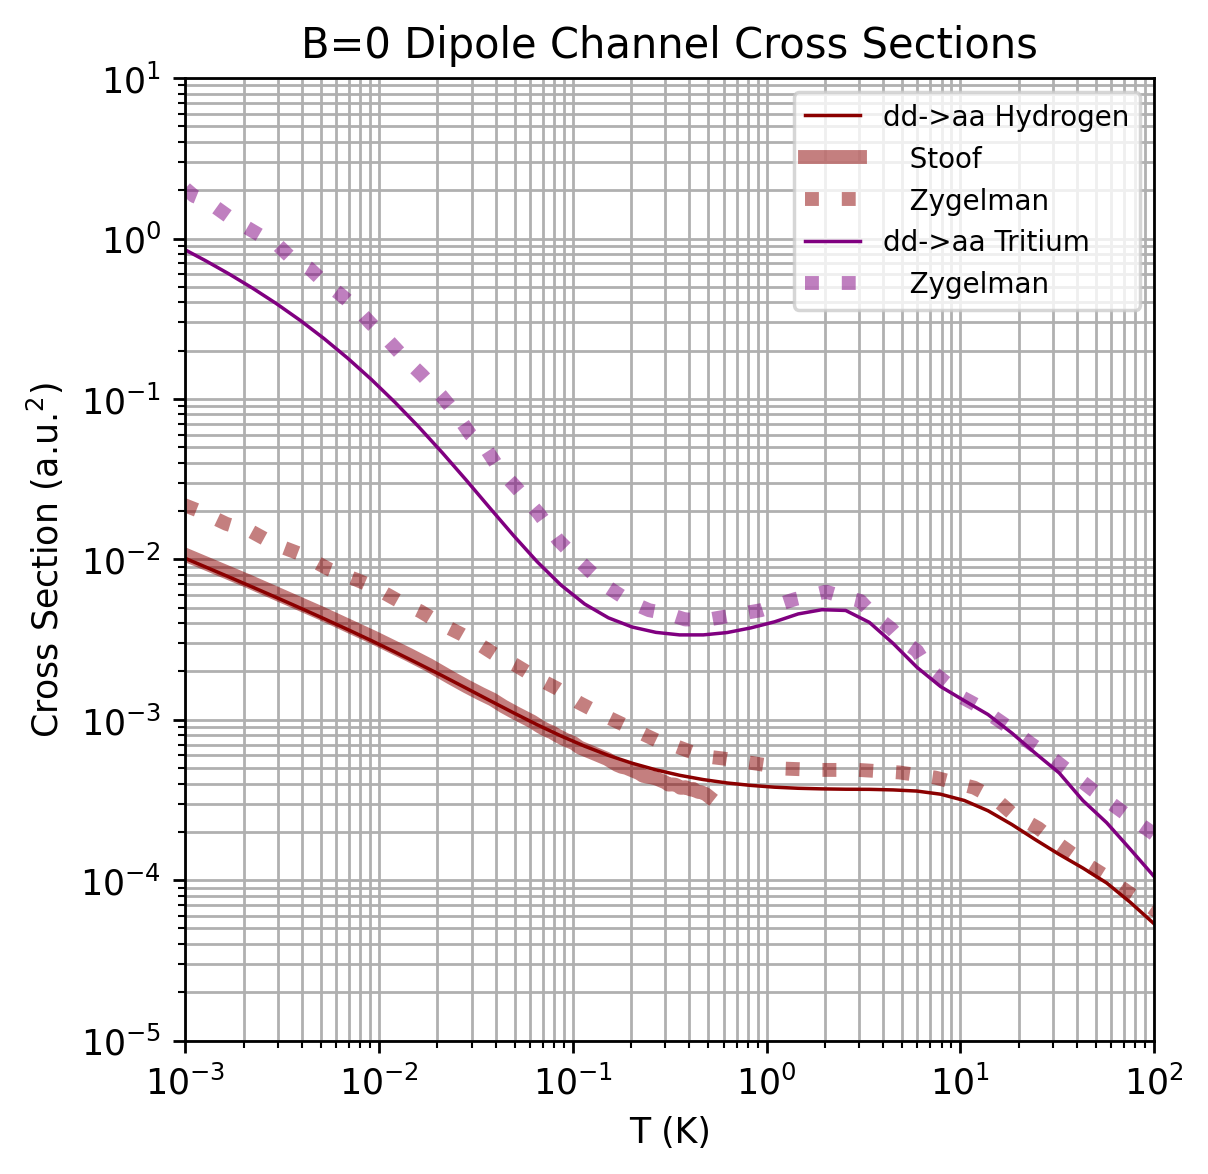

In [24]:


plt.figure(figsize=(5,5),dpi=250)
plt.plot(T_values, A*SummedG_aa_H/np.sqrt(T_values),linewidth=1,color='DarkRed',  label='dd->aa Hydrogen')
plt.plot(Stoofaax,Stoofaay,'-',  linewidth=4,color='DarkRed' ,                    label='   Stoof',alpha=0.5)
plt.plot(ZygaaKH, ZygaaSigH,':', linewidth=4,color='DarkRed',                     label='   Zygelman',alpha=0.5)

plt.plot(T_values, AT*SummedG_aa_T/np.sqrt(T_values),linewidth=1,color='purple',  label='dd->aa Tritium')
plt.plot(ZygaaKT, ZygaaSigT,':',linewidth=4,color='purple',                       label='   Zygelman',alpha=0.5)


plt.semilogy()
plt.xlabel("T (K)")
plt.ylabel(r'Cross Section (a.u.$^2$)')

plt.title("B=0 Dipole Channel Cross Sections")
plt.grid(which='both')
plt.legend(loc='upper right',fontsize=8)
plt.loglog()
plt.ylim(1e-5,10)
plt.xlim(1e-3,100)
plt.savefig("Plots/LitComparison_dd_to_aa.png",dpi=250,bbox_inches='tight')
plt.show()

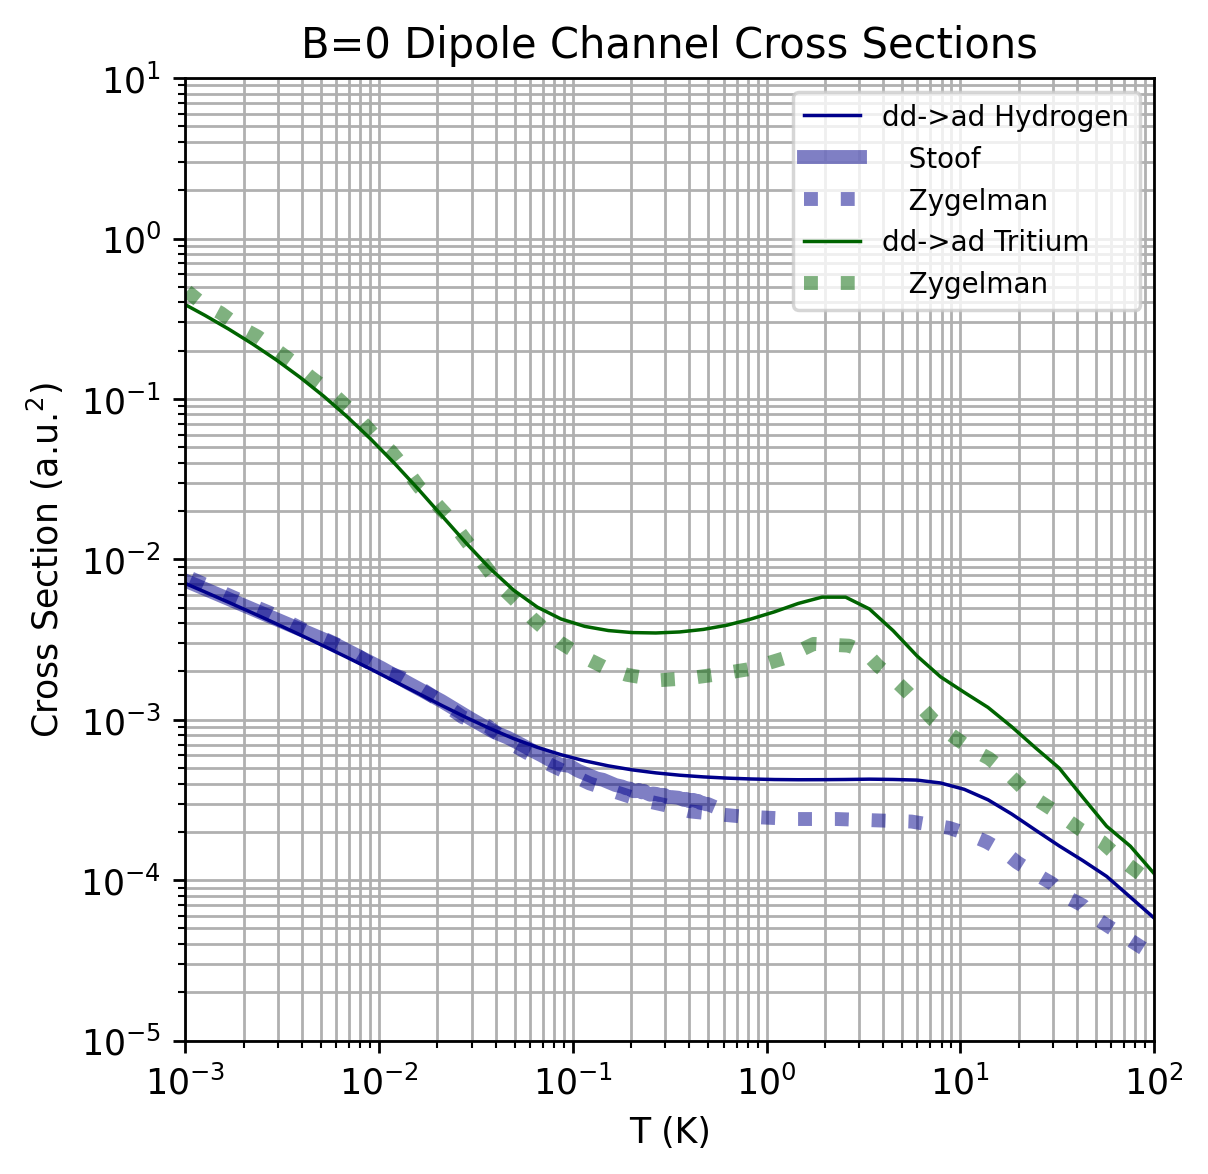

In [23]:


plt.figure(figsize=(5,5),dpi=250)


plt.plot(T_values, A*SummedG_ad_H/np.sqrt(T_values),linewidth=1,color='DarkBlue', label='dd->ad Hydrogen')
plt.plot(Stoofadx,Stoofady,'-',linewidth=4,color='DarkBlue',                      label='   Stoof',alpha=0.5)
plt.plot(ZygadKH, ZygadSigH,':',linewidth=4,color='DarkBlue',                     label='   Zygelman' ,alpha=0.5)



plt.plot(T_values,AT*SummedG_ad_T/np.sqrt(T_values),linewidth=1,color='DarkGreen',label='dd->ad Tritium')
plt.plot(ZygadKT, ZygadSigT,':',linewidth=4,color='DarkGreen',                    label='   Zygelman',alpha=0.5)


plt.semilogy()
plt.xlabel("T (K)")
#plt.xlim(0.001, 10)
plt.ylabel(r'Cross Section (a.u.$^2$)')

#plt.ylim(1e-19, 1e-15)
plt.title("B=0 Dipole Channel Cross Sections")
plt.grid(which='both')
plt.legend(loc='upper right',fontsize=8)
plt.loglog()
plt.ylim(1e-5,10)
plt.xlim(1e-3,100)
plt.savefig("Plots/LitComparison_dd_to_ad.png",dpi=250,bbox_inches='tight')
plt.show()